In [1]:
import joblib
import os
import math
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome.connectivity_matrices import sym_matrix_to_vec
from neuroginius.plotting import plot_matrix
from neuroginius.atlas import Atlas

from cogpred.utils.configuration import get_config
from cogpred.transformers import MatrixMasker
from cogpred.loading import make_training_data
from cogpred.utils.naming import make_run_path

config = get_config()
conn_dir = config["connectivity_matrices"]

ATLAS = "schaefer200"

#i_path = Path(config["parcellations"]) / ATLAS
atlas = Atlas.from_name(ATLAS, soft=False)

k = 3
REFNET = np.unique(atlas.macro_labels)
INTER = REFNET
#REFNET = ("Default",)
#INTER = ("Default",)

sns.reset_defaults()

In [2]:
matrices, metadata = make_training_data(conn_dir, ATLAS, k, test_centre=None)
run_path = make_run_path(
    config["output_dir"],
    k=k,
    feat="fc",
    atlas=ATLAS,
    net="".join(REFNET),
    inter="".join(INTER)
)

if len(run_path.name) > 55:
    print("too long")
    run_path = make_run_path(
        config["output_dir"],
        k=k,
        feat="fc",
        atlas=ATLAS,
        net="all",
    )
    
os.makedirs(run_path, exist_ok=True)
metadata.to_csv(run_path / "metadata.csv")

Dropping 12 subjects because of lacking MMMSE
too long


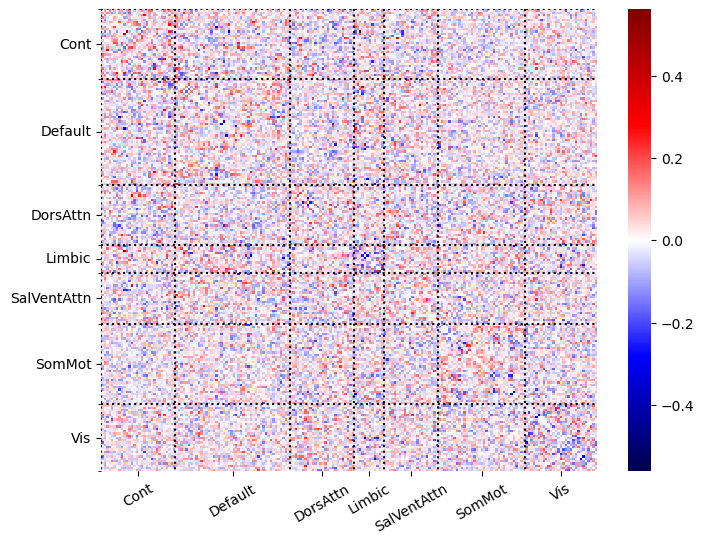

In [3]:
n_regions = matrices.shape[1]
plot_matrix(matrices[1], atlas)
plt.show()

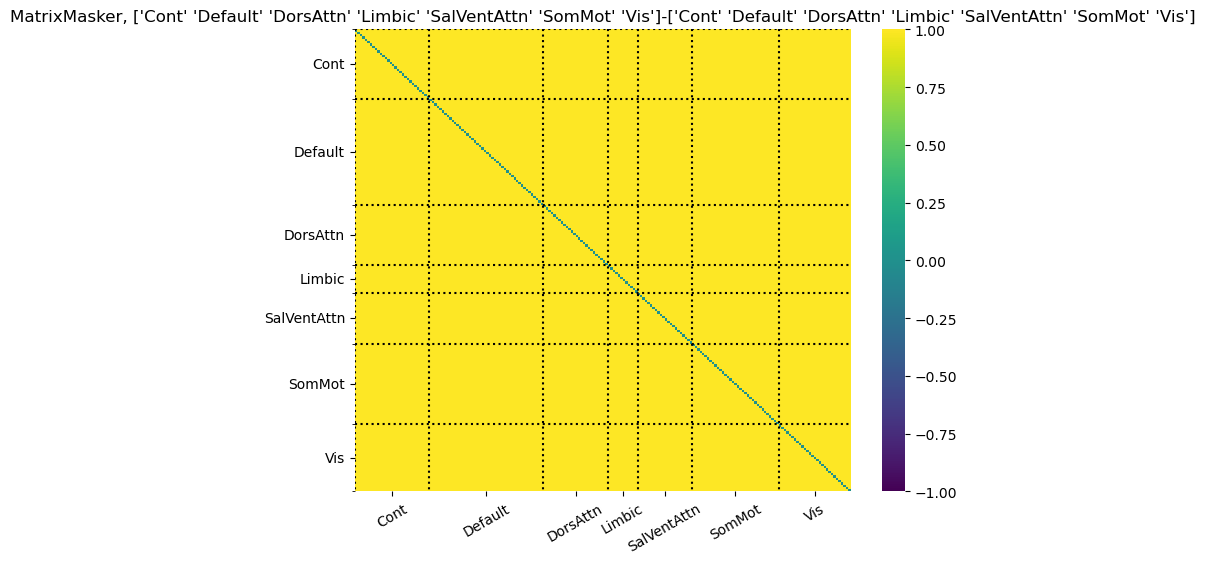

In [4]:
masker = MatrixMasker(REFNET, INTER, atlas=atlas).fit(matrices, metadata)

masker.fit(matrices).plot(cmap="viridis")
plt.show()

In [24]:
from sklearn.linear_model import ElasticNet
from cogpred.supervised import run_cv
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import StratifiedGroupKFold

net = SGDClassifier(
    loss="log_loss",
    penalty="l1",
    max_iter=1000,
    random_state=1999,
    class_weight=None
)

clf = Pipeline(
    [
    ("matrixmasker", MatrixMasker(REFNET, INTER, atlas=atlas)),
    ("scaler", preprocessing.StandardScaler()),
    ("classifier", net)
    ],
    verbose=False
)


cats = ("stable", "slow", "steep")
outer_cv = StratifiedGroupKFold(n_splits=8, shuffle=True, random_state=1999)

atlas = masker.atlas
n_features = masker.topology_.sum()
l = len(masker.vec_idx_)
rng = np.random.default_rng(seed=1002)


test_scores, cm, hmat = run_cv(clf, matrices, metadata, outer_cv)
    

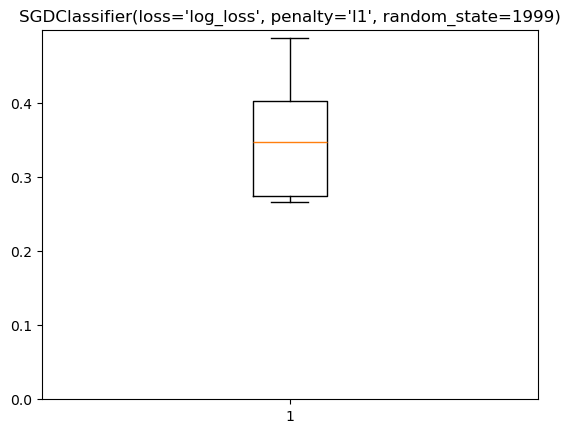

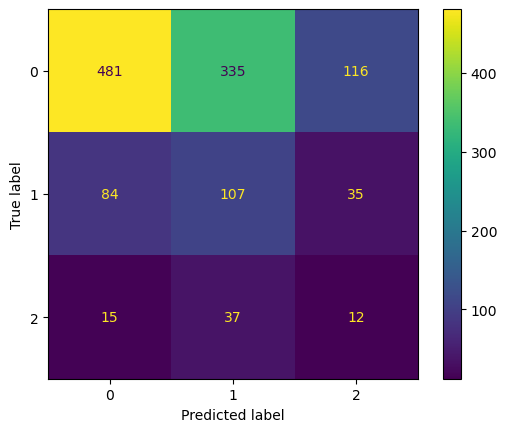

In [25]:
from sklearn.metrics import ConfusionMatrixDisplay
plt.boxplot(test_scores)
plt.ylim(0)
plt.title(clf.named_steps["classifier"])
plt.show()

disp = ConfusionMatrixDisplay(cm.astype(int))
disp.plot()
plt.show()

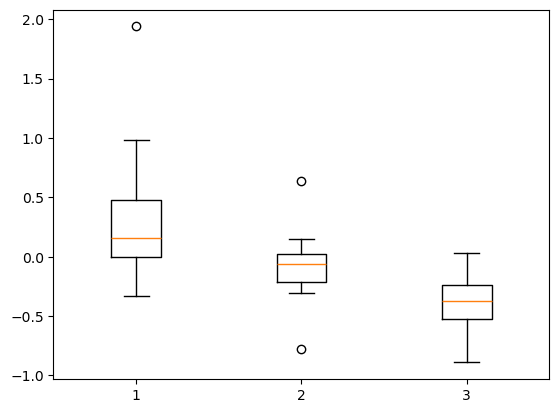

In [28]:
r_stable = hmat[:, 0, ...].mean(axis=(1, 2))
r_slow = hmat[:, 1, ...].mean(axis=(1, 2))
r_steep = hmat[:, 2, ...].mean(axis=(1, 2))
plt.boxplot(
    (
        r_stable,
        r_slow,
        r_steep,
    )
)
plt.show()

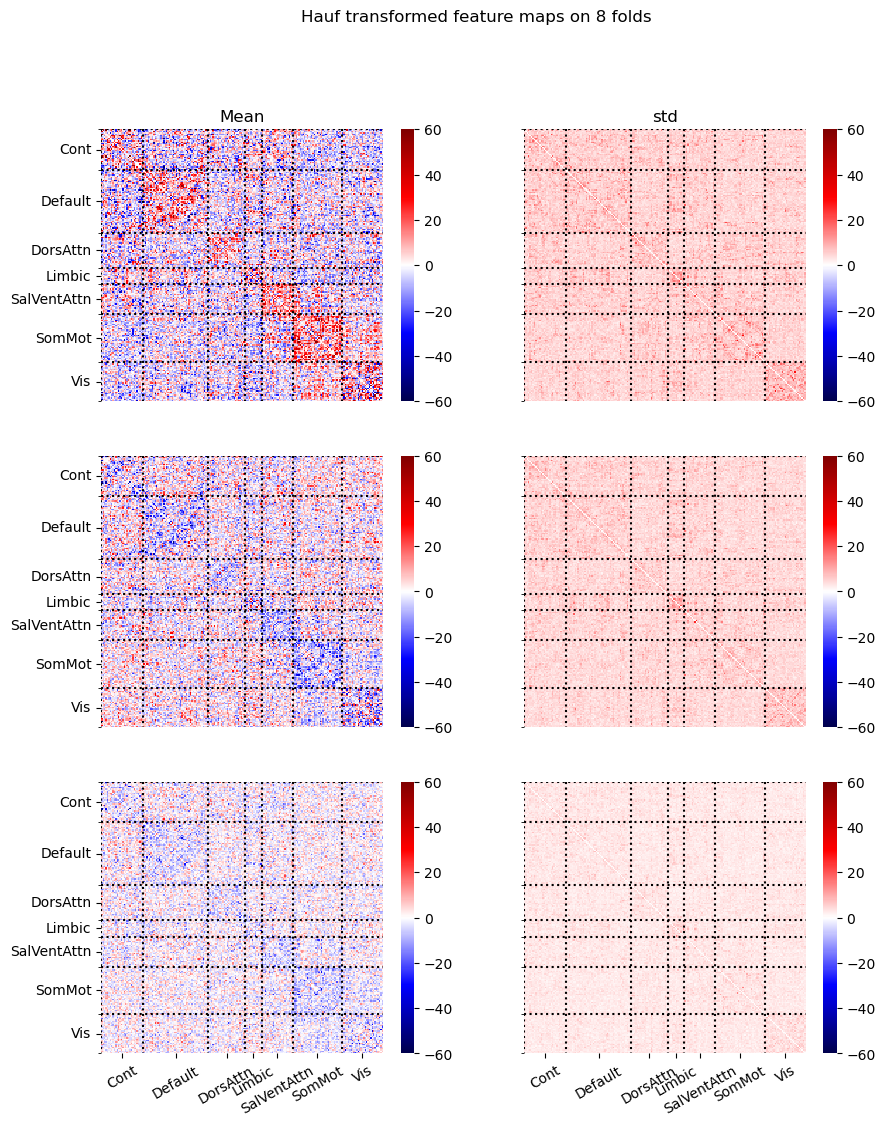

In [29]:
atlas = Atlas.from_name(ATLAS)
def net_select(label):
    if label in masker.refnet or label in masker.interaction:
        return 1
    return 0

regions = []
for region, network in zip(atlas.labels, atlas.macro_labels):
    if network in masker.refnet or network in masker.interaction:
        regions.append(region)

# Hack to remove that annoying dtype thing from nilearn
regions = list(np.array(regions).astype(str))

class MockAtlas:
    def __init__(self) -> None:
        self.macro_labels = list(map(self.region_split, regions))

    @staticmethod
    def region_split(label):
        return label.split("_")[-2]
        
if np.all(REFNET == np.unique(atlas.macro_labels)):
    disp_atlas = atlas
else:
    disp_atlas = MockAtlas()


fig, axes = plt.subplots(3, 2, figsize=(10, 12))

for i, cat in enumerate(cats):
    meanmap = np.mean(hmat[:, i, ...], axis=0)
    stdmap = np.std(hmat[:, i, ...], axis=0)

    plot_matrix(
        meanmap,
        disp_atlas,
        axes=axes[i, 0],
        bounds=(-60, 60),
        cmap="seismic",
    )
    plot_matrix(
        stdmap,
        disp_atlas,
        axes=axes[i, 1],
        bounds=(-60, 60),
        cmap="seismic",
    )
    axes[i, 1].set(yticklabels=[])
    axes[i, 1].tick_params(left=False)
    if i < 2:
        axes[i, 0].set(xticklabels=[])
        axes[i, 0].tick_params(bottom=False)
        axes[i, 1].set(xticklabels=[])
        axes[i, 1].tick_params(bottom=False)
        
    
axes[0, 0].set_title("Mean")
axes[0, 1].set_title("std")
fig.suptitle(f"Hauf transformed feature maps on {len(hmat)} folds")
plt.show()
# TODO Assume normality and threshold with t-tests? Since data is z transformed it should be ok

In [ ]:
import joblib
cv_results.to_csv(run_path / "cv_results.csv")
#joblib.dump(test_scores, run_path / "test_scores.joblib")
joblib.dump(search.best_estimator_, run_path / "best_estimator.joblib")

['/homes_unix/jlegrand/data/Memento/output/prediction/k-3_feat-fc_atlas-ncomponents-10_nregions-39_gsr-False_net-all/best_estimator.joblib']